In [1]:
import pandas as pd
import numpy as np
import os
import gzip
import pickle
import re
import cycler

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

- 12.083.748/0001-84 - KAPITALO MASTER II FUNDO DE INVESTIMENTO MULTIMERCADO
- 11.419.627/0001-06 - ITAÚ HEDGE PLUS MULTIMERCADO - FUNDO DE INVESTIMENTO
- 24.300.684/0001-05 - GAVEA MACRO PLUS MASTER FUNDO DE INVESTIMENTO MULTIMERCADO
- 09.489.380/0001-44 - VENTOR HEDGE MASTER FUNDO DE INVESTIMENTO MULTIMERCADO
- 11.377.282/0001-67 - KAPITALO MASTER I FUNDO DE INVESTIMENTO MULTIMERCADO
- 12.083.748/0001-84 - KAPITALO MASTER II FUNDO DE INVESTIMENTO MULTIMERCADO
- 08.875.020/0001-18 - GÁVEA MACRO MASTER FUNDO DE INVESTIMENTO MULTIMERCADO
- 07.658.922/0001-30 - ITAÚ HEDGE MULTIMERCADO - FUNDO DE INVESTIMENTO
- 17.080.119/0001-14 - BAHIA MARAU
- 14.492.346/0001-69 - VOTORANTIM MASTER PLUS RF CRÉDITO PRIVADO FUNDO DE INV. EM COTAS DE FUNDOS DE INV. LONGO PRAZO (Só investe em cotas de outros fundos)
- 20.701.533/0001-08 - 'LONGCHAMP FUNDO DE INVESTIMENTO MULTIMERCADO - CREDITO PRIVADO - INVESTIMENTO NO EXTERIOR' (Investe em cotas de outros fundos)
- 20.983.041/0001-52 - ALDEBARÃ - FUNDO DE INVESTIMENTO MULTIMERCADO - CREDITO PRIVADO - INVESTIMENTO NO EXTERIOR * mais ativo
- 22.128.298/0001-52 - 'VALORA GUARDIAN MASTER FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO' * mais passivo

- 15.637.780/0001-52 - 'PAINEIRAS HEDGE MASTER FUNDO DE INVESTIMENTO MULTIMERCADO

In [83]:
data_dir = "./"
db_file = 'fundos.db'
engine = create_engine(
    "sqlite:///"+os.path.abspath(os.path.join(data_dir, db_file)))

data_inicio = '2000-01-01'
data_fim = '2017-12-31'
cnpj_fundo = '15.637.780/0001-52'  # ALASK 14.492.346/0001-69

In [84]:
# carteira e pesos
sqlquery = """
select * from cda
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
carteira = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])
pl = carteira.sort_values(['DT_COMPTC', 'FILE'])[
    'VL_PATRIM_LIQ'].fillna(method='bfill')
carteira['VL_PATRIM_LIQ'] = pl
carteira['peso'] = carteira['VL_MERC_POS_FINAL'].div(carteira['VL_PATRIM_LIQ'])

carteira = carteira[carteira.FILE != 'PL']

# Valores a pagar são negativos
q = (carteira.TP_APLIC == 'Valores a pagar') | (
    carteira.TP_APLIC.str.lower().str.contains('obriga|lançad'))
carteira.loc[q, ['VL_MERC_POS_FINAL', 'peso']] *= -1


In [85]:
carteira.sort_values('peso', ascending=False).iloc[:5].columns

Index(['Id', 'AG_RISCO', 'BV_MERC', 'CD_ATIVO', 'CD_ATIVO_BV_MERC',
       'CD_BV_MERC', 'CD_INDEXADOR_POSFX', 'CD_ISIN', 'CD_PAIS', 'CD_SELIC',
       'CD_SWAP', 'CNPJ_EMISSOR', 'CNPJ_FUNDO', 'CNPJ_FUNDO_COTA',
       'CPF_CNPJ_EMISSOR', 'DENOM_SOCIAL', 'DS_ATIVO', 'DS_ATIVO_EXTERIOR',
       'DS_INDEXADOR_POSFX', 'DS_SWAP', 'DT_COMPTC', 'DT_CONFID_APLIC',
       'DT_EMISSAO', 'DT_FIM_VIGENCIA', 'DT_INI_VIGENCIA', 'DT_RISCO',
       'DT_VENC', 'EMISSOR', 'EMISSOR_LIGADO', 'GRAU_RISCO', 'INVEST_COLETIVO',
       'INVEST_COLETIVO_GESTOR', 'NM_FUNDO_COTA', 'PAIS', 'PF_PJ_EMISSOR',
       'PR_CUPOM_POSFX', 'PR_INDEXADOR_POSFX', 'PR_TAXA_PREFX',
       'QT_AQUIS_NEGOC', 'QT_ATIVO_EXTERIOR', 'QT_POS_FINAL', 'QT_VENDA_NEGOC',
       'RISCO_EMISSOR', 'TITULO_POSFX', 'TITULO_CETIP', 'TITULO_GARANTIA',
       'CNPJ_INSTITUICAO_FINANC_COOBR', 'TP_APLIC', 'TP_ATIVO', 'TP_FUNDO',
       'TP_NEGOC', 'TP_TITPUB', 'FILE', 'VL_AQUIS_NEGOC', 'VL_ATIVO_EXTERIOR',
       'VL_CUSTO_POS_FINAL', 'VL_MERC_PO

In [86]:
carteira.TP_ATIVO.unique()

array(['Título público federal', 'Fundo de Investimento e de Cotas',
       'Futuro de DI1:DI de 1 dia', 'Opção de venda', 'Opção de compra',
       'Futuro de DOL:Dólar comercial', 'Futuro de DDI:Cupom cambial',
       'Futuro de IND:Ibovespa', 'Contrato Futuro', 'Outros'],
      dtype=object)

In [87]:
carteira.DT_COMPTC.min()

Timestamp('2012-09-30 00:00:00')

In [88]:
carteira.DENOM_SOCIAL.min()

'PAINEIRAS HEDGE MASTER FUNDO DE INVESTIMENTO MULTIMERCADO'

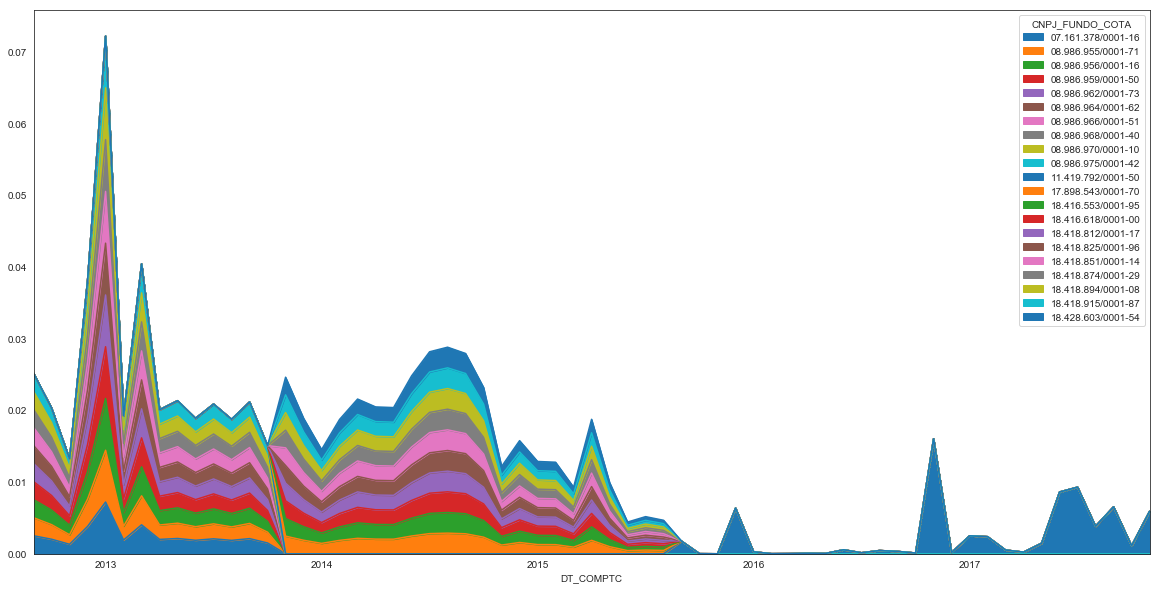

In [89]:
carteira.groupby(["DT_COMPTC", 'CNPJ_FUNDO_COTA'])['peso'].sum().unstack().plot.area(figsize=(20,10), )

In [9]:
sqlquery = """
select CNPJ_FUNDO, count(DISTINCT CNPJ_FUNDO_COTA) as cnt from cda
WHERE NOT CNPJ_FUNDO_COTA IS NULL
GROUP BY CNPJ_FUNDO, DT_COMPTC
HAVING count(DISTINCT CNPJ_FUNDO_COTA) > 2
limit 10
"""
pd.read_sql(sqlquery,engine)

,CNPJ_FUNDO,cnt
0,00.000.432/0001-00,3
1,00.000.432/0001-00,3
2,00.000.432/0001-00,3
3,00.000.432/0001-00,3
4,00.000.432/0001-00,3
5,00.000.432/0001-00,3
6,00.000.432/0001-00,3
7,00.000.432/0001-00,3
8,00.000.432/0001-00,3
9,00.000.432/0001-00,3
